# Toxic Comment Classification Challenge

<img src="images/brand.png">

In this Kaggle competition, the goal is to develop a model to detect **toxic comments** in online discussions. The problem is focused on identifying harmful and offensive comments that can make online platforms hostile and unwelcoming for users. By detecting such comments, platforms can take action to make online conversations more respectful and productive.

### What is the Problem?

Many people stop expressing their opinions online due to the presence of toxic comments, such as harassment, abuse, and threats. Online platforms often struggle to effectively identify and filter these harmful comments, leading to restrictions on user participation. As a result, some platforms limit or shut down comment sections entirely.

The goal of this competition is to build a **multi-headed model** that can detect different types of toxic behavior, such as threats, obscenity, insults, and identity-based hate. The dataset you will work with contains comments from Wikipedia’s talk pages, and the challenge is to improve the existing models for identifying these behaviors.

### What You Need to Do:

1. **Analyze the dataset:** The dataset contains comments from Wikipedia talk pages, each labeled with various types of toxicity (e.g., threat, insult, identity hate). You will need to explore the data to understand these labels.

2. **Build a multi-headed model:** Develop a model that can detect multiple types of toxic behavior simultaneously. For example, some platforms might tolerate profanity but have strict policies against identity-based hate speech. Your model should be able to handle these distinctions.

3. **Predict multiple toxicity types:** The model should be able to differentiate between different kinds of toxicity, such as threats, obscenity, insults, and identity-based hate.

4. **Improve the current models:** Your model should outperform the existing ones used in the Perspective API, which are already capable of detecting toxicity but still make errors. Additionally, the current models don't allow platforms to select specific types of toxicity to filter, which your model should aim to improve.

### Evaluation Metric:

The models in this competition will be evaluated using the **Mean Column-wise ROC AUC** metric. This means that the Area Under the Curve (AUC) will be calculated for each toxicity category separately, and then the average of these AUC scores will be taken. AUC measures the performance of a classification model, with a score of 0.5 representing random predictions and 1.0 representing perfect classification.

### Summary

The main goal of this competition is to develop a model that can accurately detect various types of toxic comments in online discussions. By improving the performance of these models, the hope is that online conversations can become more respectful and productive.


In [1]:
!pip install neattext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 8.3 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()  # Bu adımda sana kaggle.json dosyasını yüklemen için bir dosya seçici açılacak.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zafermesutblen","key":"995425ec3b85ccd5b3968c2fab0c6f1b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install -q kaggle

In [5]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 99% 52.0M/52.6M [00:03<00:00, 18.8MB/s]
100% 52.6M/52.6M [00:03<00:00, 14.3MB/s]


In [6]:
!unzip jigsaw-toxic-comment-classification-challenge.zip

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

from wordcloud import WordCloud
from wordcloud import STOPWORDS

import neattext.functions as nfx

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

warnings.filterwarnings("ignore")

In [8]:
df_train = pd.read_csv('train.csv.zip')
df_test = pd.read_csv('test.csv.zip')

## EDA - Exploratory Data Analysis

In [9]:
df_train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
44975,78421124381270a2,Not dense at all. WP is entirely appropriate a...,0,0,0,0,0,0
124583,9a7c7158fc53d3b0,"Again, you are manipulating the statement and ...",1,0,0,0,0,0
61237,a3e7dda88aa2ac9c,"Well, help would be welcome\nI don't think sta...",0,0,0,0,0,0
141868,f6f627f991226171,I have NO criminal history and your comment is...,0,0,0,0,0,0
139825,ec4b5e410bdfd194,as I have with you. Godspeed.,0,0,0,0,0,0


In [10]:
df_train.shape

(159571, 8)

In [11]:
df_test.shape

(153164, 2)

In [12]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_train['none'] = 1 - df_train[label_cols].max(axis=1)
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


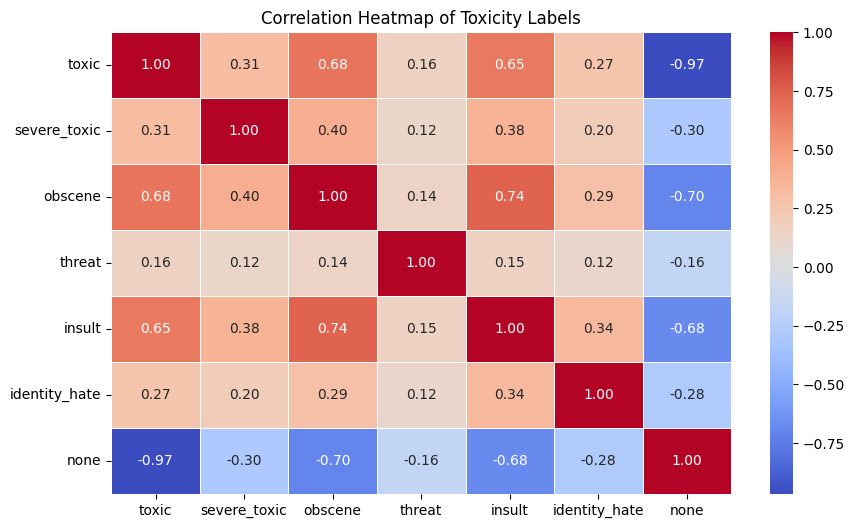

In [13]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','none']
plt.figure(figsize=(10, 6))
sns.heatmap(df_train[labels].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Toxicity Labels")
plt.show()


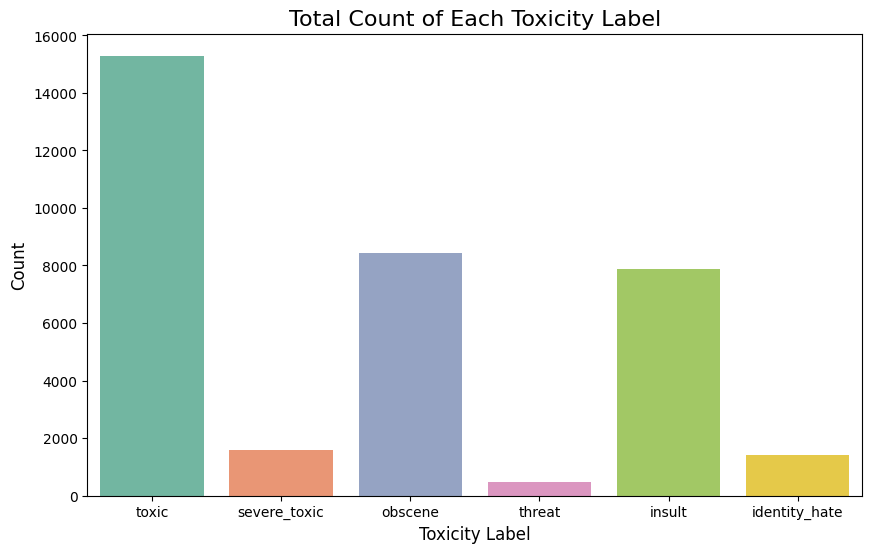

In [14]:
label_counts = df_train[label_cols].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')
plt.title('Total Count of Each Toxicity Label', fontsize=16)
plt.xlabel('Toxicity Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

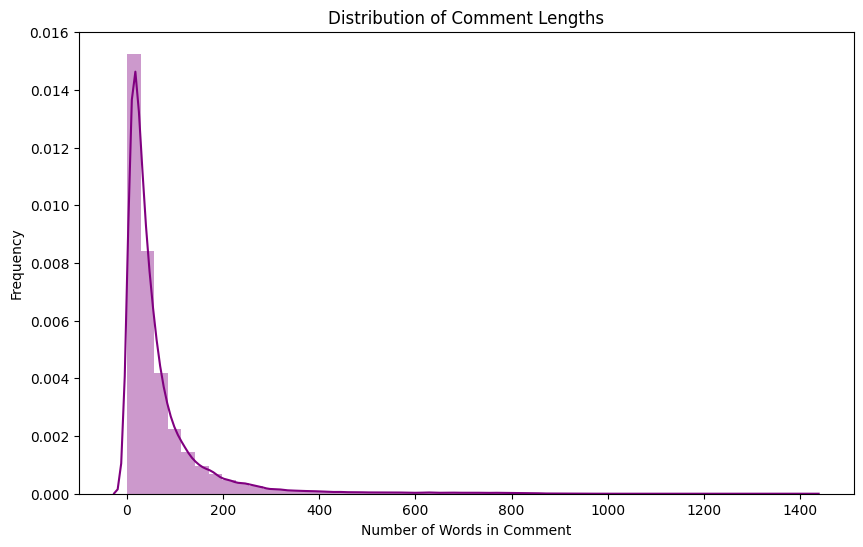

In [15]:
df = df_train.copy()
df['comment_length'] = df['comment_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.distplot(df['comment_length'], bins=50, kde=True, color='purple')
plt.title("Distribution of Comment Lengths")
plt.xlabel("Number of Words in Comment")
plt.ylabel("Frequency")
plt.show()


In [16]:
def wc(data, bgcolor):
    plt.figure(figsize = (10,10))
    wc = WordCloud(background_color = bgcolor, stopwords= STOPWORDS)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [17]:
none_comments = df_train[df_train['none'] == 1]['comment_text']
toxic_comments = df_train[df_train['toxic'] == 1]['comment_text']
identity_hate_comments = df_train[df_train['identity_hate'] == 1]['comment_text']

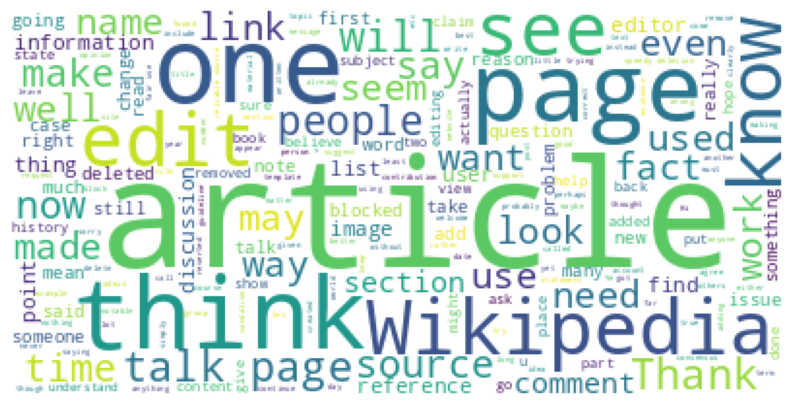

In [18]:
wc(none_comments, 'white')

I’ve commented out the other word clouds due to inappropriate language, but feel free to run them if you’d like to view them.

In [19]:
# wc(toxic_comments, 'black')

In [20]:
# wc(identity_hate_comments, 'white')

## Cleaning the text

In [21]:
def clean_text(text):
    text = nfx.normalize(text)
    text = nfx.remove_emails(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_special_characters(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_punctuations(text)
    text = nfx.remove_numbers(text)
    text = nfx.remove_emojis(text)
    text = nfx.remove_html_tags(text)
    return text

df_train['comment_text'] = df_train['comment_text'].apply(clean_text)

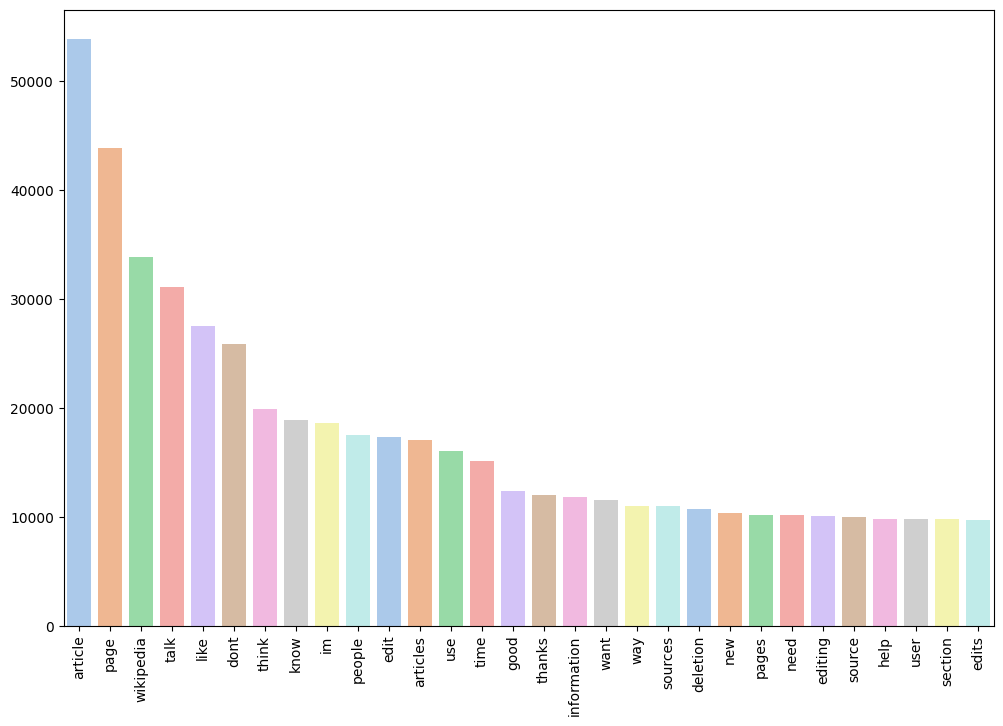

In [22]:
from collections import Counter
s =' '.join(df_train['comment_text'].tolist())
data = Counter(s.split()).most_common(30)
data = dict(data)

plt.figure(figsize=(12,8))
sns.barplot(x=list(data.keys()), y=list(data.values()) , palette='pastel')
plt.xticks(rotation=90);

## Vectorizer

In [23]:
test = df_test['comment_text']
train = df_train['comment_text']
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
labels_train = df_train[classes].values

In [24]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train))
list_tokenized_train = tokenizer.texts_to_sequences(train)
list_tokenized_test = tokenizer.texts_to_sequences(test)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

In [26]:
maxlen = 150
z_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
z_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

## Modelling with LSTM

In [27]:
model = Sequential([
    layers.Input( shape = (maxlen, )),
    layers.Embedding(max_features, 128),
    LSTM(100, return_sequences = True),
    GlobalMaxPool1D(),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stopping = EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)


history = model.fit(
    z_train, labels_train,
    batch_size= 128,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping],
)

Epoch 1/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9066 - loss: 0.1307
Epoch 2/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.9937 - loss: 0.0522
Epoch 3/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9915 - loss: 0.0490
Epoch 4/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.9907 - loss: 0.0446
Epoch 5/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9898 - loss: 0.0416
Epoch 6/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9870 - loss: 0.0374
Epoch 7/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9816 - loss: 0.0342
Epoch 8/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9524 - loss: 0.0316
Epoch 9/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9091 - loss: 0.0294
Epoch 10/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.8631 - loss: 0.0268
Epoch 11/20
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.7546 - loss: 0.0249
Epoch 12

In [31]:
pred = model.predict(z_test)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


In [32]:
predict = pd.DataFrame(pred, columns = ['toxic','severe_toxic','obscene', 'threat','insult','identity_hate'])

In [33]:
output = df_test.join(predict)

In [34]:
output

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,9.998964e-01,4.719420e-01,9.999969e-01,6.951007e-02,9.974485e-01,1.290994e-01
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,9.545158e-09,4.031030e-11,6.170737e-08,3.284437e-08,2.134458e-08,9.309633e-09
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",2.996535e-04,1.863813e-06,6.511367e-05,3.674196e-06,2.383026e-05,3.015979e-06
3,00017563c3f7919a,":If you have a look back at the source, the in...",8.165190e-08,2.511023e-12,3.012147e-08,1.825590e-09,1.321105e-09,2.369852e-11
4,00017695ad8997eb,I don't anonymously edit articles at all.,1.002081e-08,3.491525e-13,3.154643e-09,1.603352e-09,4.145512e-10,3.222935e-10
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",3.657578e-02,1.201853e-06,5.620992e-02,8.311939e-06,4.099857e-03,9.339948e-06
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,9.073874e-10,1.312519e-14,3.996380e-12,3.175743e-09,9.419622e-13,9.483914e-08
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",3.752761e-09,4.496574e-21,9.123571e-15,5.792876e-17,1.044168e-15,5.823249e-18
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",1.936043e-12,1.333969e-15,8.400439e-12,1.791996e-11,1.022086e-13,1.038963e-11


In [35]:
output.drop('comment_text', axis=1, inplace=True)

In [36]:
output.to_csv('submission.csv', index=False)

In [ ]:
model.save('model_lstm.keras')